In [1]:
from datasets import load_dataset
dset = load_dataset("kresnik/librispeech_asr_test", "clean")['test']
# dset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
dset = dset.remove_columns(['speaker_id', 'chapter_id','id'])
print(dset)

import numpy as np
from datasets import load_metric
wer_metric = load_metric("wer")

Reusing dataset librispeech_asr (/home-nfs/goutham/.cache/huggingface/datasets/kresnik___librispeech_asr/clean/2.1.0/16bc288fa237b20821c5b51c8c09426b2689d8c5a889287589cb12aba6705e74)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 2620
})


In [2]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import matplotlib.pyplot as plt
import numpy as np

import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").cuda()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter 'function'=<function transcript at 0x7f5cb02608b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

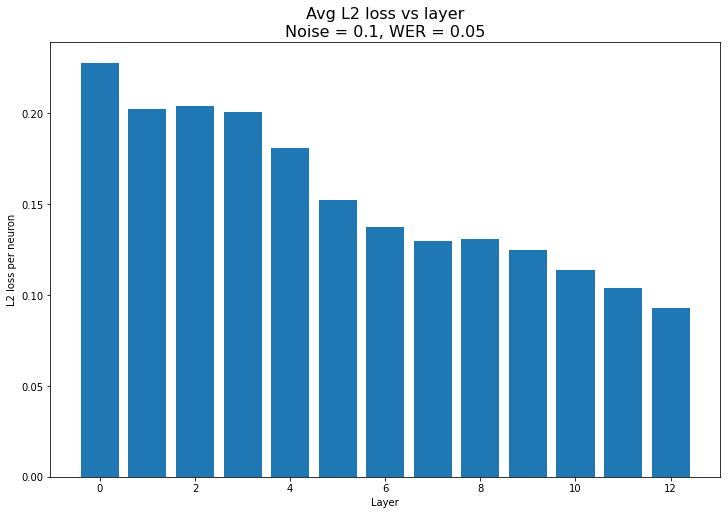

In [3]:
avg_loss = [[] for i in range(13)]

def transcript(batch):
    speech = batch["audio"]["array"]
    input_values = w2v_processor(speech, sampling_rate = 16000, return_tensors="pt", padding="longest").input_values
    input_values = input_values.to("cuda")
    
    outputs = w2v_model(input_values, output_hidden_states = True)
    
    hidden_states = outputs.hidden_states
    noise = 0.1
    corr_inputs = input_values + torch.randn_like(input_values) * noise
    corr_outputs = w2v_model(corr_inputs, output_hidden_states = True)
    corr_hidden_states = corr_outputs.hidden_states
    for i in range(13):
        avg_loss[i].append(float(torch.norm(corr_hidden_states[i] - hidden_states[i])) / np.sqrt(torch.numel(hidden_states[i])))
        
    logits = corr_outputs.logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
    return batch

new_dset = dset.map(transcript, 
                batch_size = 1,
                load_from_cache_file=False)

wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])

avg_loss = np.mean(np.array(avg_loss), axis=1)
fig = plt.figure(figsize=(12, 8))
plt.bar(list(range(0, 13)), list(avg_loss))
plt.xlabel("Layer")
plt.ylabel("L2 loss per neuron")
plt.title("Avg L2 loss vs layer\nNoise = {}, WER = {}".format(0.1, np.round(wer, 2)), fontsize=16)
plt.savefig("avg_l2_loss_layers.pdf")
plt.show()

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

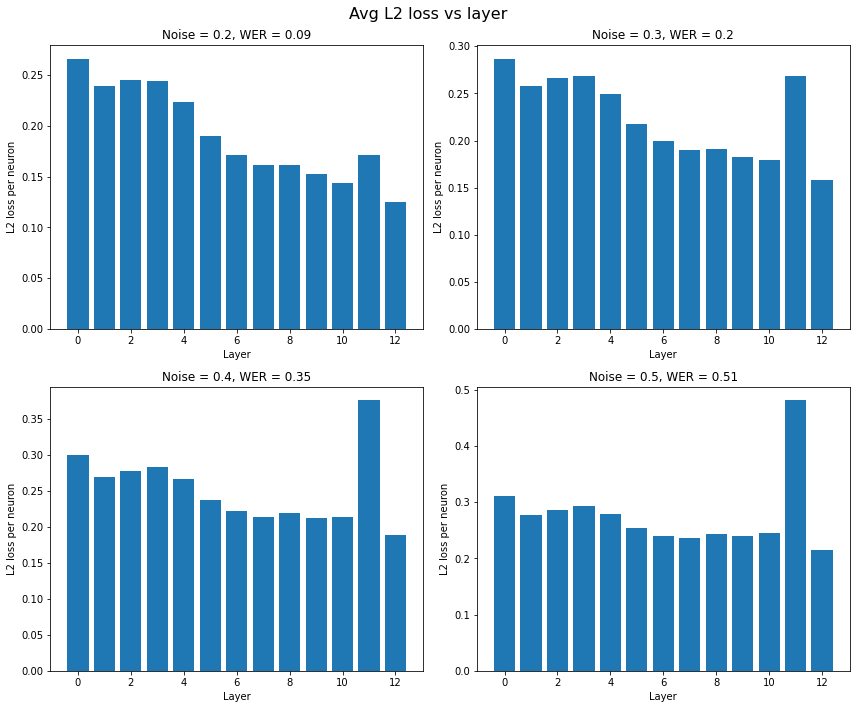

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for counter, noise in enumerate([.2, .3, .4, .5]):
    avg_loss = [[] for i in range(13)]
    def transcript(batch):
        speech = batch["audio"]["array"]
        input_values = w2v_processor(speech, sampling_rate = 16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to("cuda")

        outputs = w2v_model(input_values, output_hidden_states = True)

        hidden_states = outputs.hidden_states
        corr_inputs = input_values + torch.randn_like(input_values) * noise
        corr_outputs = w2v_model(corr_inputs, output_hidden_states = True)
        corr_hidden_states = corr_outputs.hidden_states
        for i in range(13):
            avg_loss[i].append(float(torch.norm(corr_hidden_states[i] - hidden_states[i])) / np.sqrt(torch.numel(hidden_states[i])))

        logits = corr_outputs.logits
        pred_ids = torch.argmax(logits, dim=-1)
        batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
        return batch

    new_dset = dset.map(transcript, 
                    batch_size = 1,
                    load_from_cache_file=False)

    wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])

    avg_loss = np.mean(np.array(avg_loss), axis=1)
    
    axes[counter // 2, counter % 2].bar(list(range(0, 13)), list(avg_loss))
    axes[counter // 2, counter % 2].set_title("Noise = {}, WER = {}".format(noise, np.round(wer, 2)))
    axes[counter // 2, counter % 2].set_xlabel("Layer")
    axes[counter // 2, counter % 2].set_ylabel("L2 loss per neuron")

plt.suptitle("Avg L2 loss vs layer", fontsize=16)
fig.tight_layout()
plt.savefig("layer11.pdf")
plt.show()    